In [201]:
%load_ext autoreload
%autoreload 2

from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from copy import deepcopy
from tqdm import tqdm
import importlib
from helpers import NormalizedEnv

from heuristicpolicy import HeuristicPendulumAgent
from qnetwork import QNetwork
from policynetwork import PolicyNetwork
from gaussian_action_noise import GaussianActionNoise
from replaybuffer import ReplayBuffer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:


#Create random agent
random_agent = RandomAgent(pendulum)
heuristic_agent = HeuristicPendulumAgent(pendulum)

In [202]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [207]:
MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99

In [208]:
torch.manual_seed(-1)

#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

noise = GaussianActionNoise()

network  = QNetwork().to(device) # critic
policy_network = PolicyNetwork().to(device) # actor

memory = ReplayBuffer(max_size=200)

In [209]:
#target_actor = HeuristicPendulumAgent(pendulum).to(device)

policy_optimizer  = optim.Adam(policy_network.parameters(),  lr=LEARNING_RATE)

MSE = nn.MSELoss()

In [212]:
state

tensor([0.8433, 0.5375, 0.6844])

In [211]:
policy_network(state)

tensor([0.1081], grad_fn=<TanhBackward0>)

In [213]:
network_input_state = torch.cat((state, policy_network(state)))
network_input_state

tensor([0.8433, 0.5375, 0.6844, 0.1081], grad_fn=<CatBackward0>)

In [214]:
targets = []
q_state = []
policy_loss = 0
for i in range(BATCH_SIZE):

    state, action, reward, next_state, trunc = batch_transitions[i]

    state = torch.FloatTensor(state).to(device)
    action = torch.FloatTensor([action]).to(device)
    reward = torch.FloatTensor([reward]).to(device) #.unsqueeze(1)
    trunc = torch.Tensor([np.float32(trunc)]).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state).to(device)

    #compute loss for actor
    policy_optimizer.zero_grad()
    # N.B.: do not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # you have to compute them with the current actor - DDPG is an off-policy algorithm
    network_input_state = torch.cat((state, policy_network(state)))
    policy_loss += -network(network_input_state)
    
    

policy_loss = policy_loss/BATCH_SIZE
policy_loss.backward()
policy_optimizer.step()
policy_loss.item()
    

0.26541709899902344

In [178]:
def learning_policy(batch_transitions, agent, gamma, network):

    targets = []
    q_state = []
    policy_loss = 0
    for i in range(BATCH_SIZE):

        state, action, reward, next_state, trunc = batch_transitions[i]

        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor([action]).to(device)
        reward = torch.FloatTensor([reward]).to(device) #.unsqueeze(1)
        trunc = torch.Tensor([np.float32(trunc)]).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)

        #compute loss for actor
        policy_optimizer.zero_grad()
        # N.B.: do not use the ”on-trajectory” actions, 
        # which were computed by a previous version of the policy network, 
        # you have to compute them with the current actor - DDPG is an off-policy algorithm
        network_input_state = torch.cat((state, policy_network(state)))
        policy_loss += -network(network_input_state)
        
        

    policy_loss = policy_loss/BATCH_SIZE
    policy_loss.backward()
    policy_optimizer.step()
    
    return policy_loss.item()

In [163]:

i = 0
# collect experience
current_state = deepcopy(pendulum.reset()[0])
while i < MAX_IT:
    # how many iterations??
    action = heuristic_agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action)
    next_state, reward, term, trunc, info = pendulum.step(transformed_action)

    memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)
    i += 1

In [179]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
nr_of_samples = 128


In [188]:
losses = []
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step=0

    i = 0
    # collect experience
    while i < MAX_IT:
        # how many iterations??
        action = heuristic_agent.compute_action(state = current_state)
        transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(transformed_action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        current_state = deepcopy(next_state)
        ep_reward += reward
        i += 1

    # sample a batch of transitions from the replay buffer
    indices = np.random.randint(0, 200, nr_of_samples)
    batch_transitions = memory.sample_transition(indices)

    # 1-step TD-learning rule
    loss = onestepTD(batch_transitions, heuristic_agent, GAMMA, network)
    losses.append(loss/nr_of_samples)
    # plot_q.append([loss, episode])

    

 32%|███▏      | 317/1000 [01:39<02:45,  4.14it/s]

In [166]:
plt.print(losses)

2344.7842063289863

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

Text(0.5, 1.0, 'Q loss')

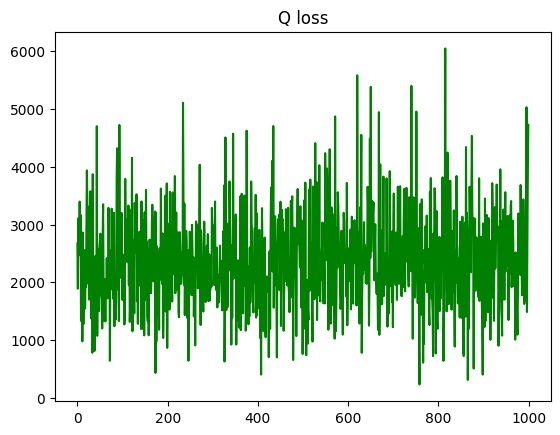

In [186]:
q = list(zip(*plot_q))
plt.plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
plt.title('Q loss')

In [187]:
i = 0
while i < MAX_IT:
    action = heuristic_agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action)
    next_state, reward, term, trunc, info = pendulum.step(transformed_action)

    memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

    current_state = deepcopy(next_state)
    ep_reward += reward
    i += 1

[(array([0.97788984, 0.20912069, 0.18009238], dtype=float32),
  -1.0,
  -0.051627571543737774,
  array([0.9775334 , 0.2107805 , 0.03395293], dtype=float32),
  False),
 (array([ 0.95440036,  0.2985296 , -2.3184805 ], dtype=float32),
  1.0,
  -0.6334360689743704,
  array([ 0.9773568 ,  0.21159807, -1.7988373 ], dtype=float32),
  False)]